# Chatbot With Neural Network

<b>Chatbot</b> merupakan bagian dari Natural Language Processing yang digunakan untuk percakapan dengan pengguna melalui teks dan ucapan. Pada mini project ini kita akan membuat sebuah chat otomatis atau chatbot tentang pelayan perpustakaan. 

Dalam tahapan Chatbot ini ada tahapan yang harus kita perhatikan yaitu,

1. Import Library
2. Load Dataset
3. Preprocessing Data
4. Input Length, Output Length and Vocabulary
5. Neural Network Model
6. Model Analysis
7. Testing
8. Save Model

## Instalasi Library Pengenal Suara

In [1]:
!pip -q install speechrecognition

In [2]:
!pip -q install gtts

# Import Library

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM dan Jaringan Syaraf Tiruan (Neural Network).

In [3]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## Download NLTK and Sastrawi Package

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alqurtubi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alqurtubi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Alqurtubi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Load Dataset Json

In [5]:
# Importing the dataset
with open('libot.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [6]:
data.head() # Cetak data baris pertama sampai baris kelima

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [7]:
data.tail() # Cetak data baris ke-37 sampai baris akhir

,patterns,tags
37,jam buka perpustakaan dan peraturan peminjaman...,program_perpustakaan
38,Bagaimana cara mendaftar sebagai anggota perpu...,informasi_pendaftaran
39,Kapan perpustakaan buka?,jam_buka_perpustakaan
40,Bagaimana peraturan meminjam buku?,peraturan_peminjaman_buku
41,Dimana letak buku kategori...?,letak_buku_sesuai_kategori


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi tentang pelayanan di perpustakaan.

# Preprocessing The Data

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

In [8]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
5,hy,greeting
6,pagi,greeting
7,morning,greeting
8,siang,greeting
9,afternoon,greeting


In [9]:
# create stemmer and process stemmer with Sastrawi
factory = StemmerFactory() 
stemmer = factory.create_stemmer()
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

63 unique lemmatized words ['', 'afternoon', 'anggota', 'apa', 'atur', 'bagai', 'bagaimana', 'bai', 'banyak', 'bot', 'bro', 'bubay', 'buka', 'buku', 'bye', 'byee', 'cara', 'dadaa', 'dadah', 'daftar', 'dah', 'dan', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'informasi', 'jam', 'jumpa', 'kapan', 'kasih', 'kategori', 'kawan', 'layan', 'letak', 'makasih', 'malam', 'mana', 'morning', 'pagi', 'pinjam', 'program', 'pustaka', 'saja', 'sampai', 'sedia', 'see', 'selamat', 'sesuai', 'siang', 'sis', 'sore', 'terima', 'thank', 'thanks', 'tinggal', 'ya', 'yang', 'you', 'yuhuu']


In [10]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

9 classes ['goodbye', 'greeting', 'informasi_pendaftaran', 'jam_buka_perpustakaan', 'letak_buku_sesuai_kategori', 'penjelasan_layanan_perpustakaan', 'peraturan_peminjaman_buku', 'program_perpustakaan', 'terimakasih']


In [11]:
# documents = combination between patterns and intents
print (len(documents), "documents")

428 documents


In [12]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [5],
 [36],
 [37, 5],
 [38, 39],
 [40, 41],
 [42],
 [43, 6],
 [44],
 [45],
 [46],
 [47, 6],
 [7, 8],
 [9],
 [7, 8, 48],
 [9, 49],
 [10, 11, 50, 51, 1],
 [10, 11, 52, 1, 53, 54],
 [55, 56, 12, 3, 1, 13, 4, 14, 2],
 [15, 2, 57, 16],
 [12, 3, 1, 13, 4, 14, 2],
 [17, 58, 59, 60, 61, 1],
 [62, 1, 3],
 [17, 4, 63, 2],
 [64, 15, 2, 16]]

In [13]:
# Apply padding 
x_train = pad_sequences(train)

# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [14]:
print(x_train) # Padding Sequences

[[ 0  0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0  0 19]
 [ 0  0  0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0  0  0 21]
 [ 0  0  0  0  0  0  0  0 22]
 [ 0  0  0  0  0  0  0  0 23]
 [ 0  0  0  0  0  0  0  0 24]
 [ 0  0  0  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0  0 28]
 [ 0  0  0  0  0  0  0  0 29]
 [ 0  0  0  0  0  0  0  0 30]
 [ 0  0  0  0  0  0  0  0 31]
 [ 0  0  0  0  0  0  0  0 32]
 [ 0  0  0  0  0  0  0  0 33]
 [ 0  0  0  0  0  0  0  0 34]
 [ 0  0  0  0  0  0  0  0 35]
 [ 0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0 36]
 [ 0  0  0  0  0  0  0 37  5]
 [ 0  0  0  0  0  0  0 38 39]
 [ 0  0  0  0  0  0  0 40 41]
 [ 0  0  0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0  0 43  6]
 [ 0  0  0  0  0  0  0  0 44]
 [ 0  0  0  0  0  0  0  0 45]
 [ 0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0 47  6]
 [ 0  0  0  0  0  0  0  7  8]
 [ 0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  7  8 48]
 [ 0  0  0  0  0  0  0  9 49]
 [ 0  0  0

In [15]:
print(y_train) #Label Encodings

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 5 7 7 7
 7 2 3 6 4]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# Input Length, Output Length and Vocabulary

In [16]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

9


In [17]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  64
output length:  9


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari jaringan syaraf pada algoritma Neural Network.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

# Save Model Words & Classes

In [18]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

# Neural Network Model

Jaringan syaraf yang terdiri dari lapisan embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan embedding adalah input dari lapisan berulang (*recurrent*) dengan LSTM gate. Kemudian, output diratakan dan lapisan Dense digunakan dengan fungsi aktivasi softmax.

Bagian utama adalah lapisan embedding yang memberikan vektor yang sesuai untuk setiap kata dalam dataset.

In [19]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,30)(i) # Layer Embedding
x = LSTM(35, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

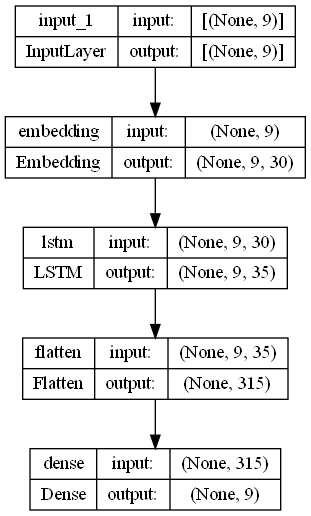

In [20]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.summary() # Menampilkan Parameter Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding (Embedding)       (None, 9, 30)             1950      
                                                                 
 lstm (LSTM)                 (None, 9, 35)             9240      
                                                                 
 flatten (Flatten)           (None, 315)               0         
                                                                 
 dense (Dense)               (None, 9)                 2844      
                                                                 
Total params: 14,034
Trainable params: 14,034
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
2/2 [==============================] - 8s 40ms/step - loss: 2.1981 - accuracy: 0.0476
Epoch 2/400
2/2 [==============================] - 0s 12ms/step - loss: 2.1814 - accuracy: 0.4286
Epoch 3/400
2/2 [==============================] - 0s 16ms/step - loss: 2.1648 - accuracy: 0.4048
Epoch 4/400
2/2 [==============================] - 0s 17ms/step - loss: 2.1456 - accuracy: 0.4048
Epoch 5/400
2/2 [==============================] - 0s 15ms/step - loss: 2.1249 - accuracy: 0.3810
Epoch 6/400
2/2 [==============================] - 0s 16ms/step - loss: 2.0975 - accuracy: 0.3810
Epoch 7/400
2/2 [==============================] - 0s 15ms/step - loss: 2.0681 - accuracy: 0.3810
Epoch 8/400
2/2 [==============================] - 0s 25ms/step - loss: 2.0306 - accuracy: 0.3810
Epoch 9/400
2/2 [==============================] - 0s 24ms/step - loss: 1.9918 - accuracy: 0.3810
Epoch 10/400
2/2 [==============================] - 0s 24ms/step - loss: 1.9401 - accuracy: 0.3810
Epoch 11/400
2/2 [=

Epoch 84/400
2/2 [==============================] - 0s 16ms/step - loss: 0.4833 - accuracy: 0.8810
Epoch 85/400
2/2 [==============================] - 0s 8ms/step - loss: 0.4655 - accuracy: 0.8810
Epoch 86/400
2/2 [==============================] - 0s 16ms/step - loss: 0.4618 - accuracy: 0.9048
Epoch 87/400
2/2 [==============================] - 0s 16ms/step - loss: 0.4499 - accuracy: 0.9048
Epoch 88/400
2/2 [==============================] - 0s 8ms/step - loss: 0.4149 - accuracy: 0.9286
Epoch 89/400
2/2 [==============================] - 0s 16ms/step - loss: 0.4008 - accuracy: 0.9048
Epoch 90/400
2/2 [==============================] - 0s 16ms/step - loss: 0.3985 - accuracy: 0.9286
Epoch 91/400
2/2 [==============================] - 0s 16ms/step - loss: 0.3785 - accuracy: 0.9286
Epoch 92/400
2/2 [==============================] - 0s 16ms/step - loss: 0.3542 - accuracy: 0.9286
Epoch 93/400
2/2 [==============================] - 0s 24ms/step - loss: 0.3421 - accuracy: 0.9524
Epoch 94/400

2/2 [==============================] - 0s 17ms/step - loss: 0.0339 - accuracy: 1.0000
Epoch 167/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0331 - accuracy: 1.0000
Epoch 168/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0325 - accuracy: 1.0000
Epoch 169/400
2/2 [==============================] - 0s 31ms/step - loss: 0.0319 - accuracy: 1.0000
Epoch 170/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0313 - accuracy: 1.0000
Epoch 171/400
2/2 [==============================] - 0s 8ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 172/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0300 - accuracy: 1.0000
Epoch 173/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0294 - accuracy: 1.0000
Epoch 174/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 175/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0283 - accuracy: 1.0000
Epoch 176/400
2

2/2 [==============================] - 0s 31ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 249/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 250/400
2/2 [==============================] - 0s 22ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 251/400
2/2 [==============================] - 0s 20ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 252/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 253/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 254/400
2/2 [==============================] - 0s 0s/step - loss: 0.0102 - accuracy: 1.0000
Epoch 255/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 256/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 257/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 258/400
2/

2/2 [==============================] - 0s 18ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 331/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 332/400
2/2 [==============================] - 0s 10ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 333/400
2/2 [==============================] - 0s 9ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 334/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 335/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 336/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 337/400
2/2 [==============================] - 0s 14ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 338/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 339/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 340/400
2

# Model Analysis

Setelah menjalankan model fitting. Selanjutnya adalah analisa model untuk melihat hasil akurasi dari model Neural Network tersebut.

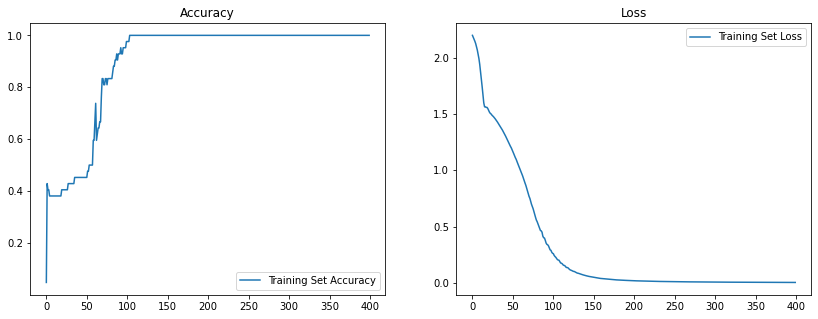

In [23]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Testing Chatbot Dan Tambahkan Suara Pada Chatbot

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya. 

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [32]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("LiBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  tts.save('LiBot.wav')
  time.sleep(0.08)
  ipd.display(ipd.Audio('LiBot.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Kamu : halo
1/1 [==============================] - 0s 66ms/step
LiBot :  Helo! Ini bot. Lagi kepo tentang layanan perpustakaan ya?



Kamu : Apa saja layanan bot perpustakaan
1/1 [==============================] - 0s 53ms/step
LiBot :  lewat bot ini teman-teman bisa mendapatkan informasi mengenai jenis-jenis layanan perpustakaan dan cara mengaksesnya



Kamu : Apa saja program perpustakaan yang tersedia
1/1 [==============================] - 0s 65ms/step
LiBot :  Mau tau tentang apa nih?



Kamu : Kapan perpustakaan buka
1/1 [==============================] - 0s 46ms/step
LiBot :  Perpustakaan buka senin-jum'at mulai pukul 08.00 pagi sampai pukul 23.00, hari libur nasional dan weekend perpustakaan tutup



Kamu : Bagaimana peraturan meminjam buku
1/1 [==============================] - 0s 57ms/step
LiBot :  Membawa kartu peminjaman buku yang bisa didapatkan setelah melakukan pendaftaran, maksimal meminjam 2 buku sekali peminjaman  dan batas waktu peminjaman 2 Minggu per buku



Kamu : Bagaimana cara mendaftar sebagai anggota perpustakaan
1/1 [==============================] - 0s 57ms/step
LiBot :  Untuk mendaftar teman-teman bisa mengisi formulir langsung di resepsionis perpustakaan, dokumen yang dibutuhkan adalah ktm/bukti krs



Kamu : Terima kasih
1/1 [==============================] - 0s 50ms/step
LiBot :  Dengan senang hati:)



Kamu : dadah
1/1 [==============================] - 0s 46ms/step
LiBot :  Bye!


# Save The Model

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. 

In [ ]:
model.save('chat_model.h5')

print('Model Created Successfully!')